<a href="https://colab.research.google.com/github/ensarakbas77/Transformer-Model-Training/blob/main/VitModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8024620065245554944
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2634167891876811596
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
!ls "/content/drive/My Drive/SPLIT_DATASET/train"

 KIFOZ	'PEKTUS EKSKAVATUM'  'PEKTUS KARINATUM'  'POLAND SENDROMU'   SKOLYOZ


In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

# Eğitim veri kümesini yükleme
train_dir = "/content/drive/My Drive/SPLIT_DATASET/train"
test_dir = "/content/drive/My Drive/SPLIT_DATASET/test"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Veri kümesini normalleştirme
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 10531 files belonging to 5 classes.
Found 2632 files belonging to 5 classes.


In [ ]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import time

In [ ]:
img_size = 224
patch_size = 8
num_patches = (img_size // patch_size) ** 2
num_classes = 5

# Model parametreleri
input_shape = (img_size, img_size, 3)
projection_dim = 64
transformer_layers = 3
num_heads = 2
mlp_dim = 128
dropout_rate = 0.1

# Yama çıkarma katmanı
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Yama gömme katmanı
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        embedded_patches = self.projection(patch) + self.position_embedding(positions)
        return embedded_patches

# Transformer blok katmanı
def transformer_block(inputs, num_heads, mlp_dim, dropout_rate):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    x = layers.Dropout(dropout_rate)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(mlp_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# ViT modeli oluşturma
def create_vit_model(input_shape, patch_size, num_patches, projection_dim, transformer_layers, num_heads, mlp_dim, dropout_rate, num_classes):
    inputs = layers.Input(shape=input_shape)
    patches = PatchExtractor(patch_size)(inputs)
    embedded_patches = PatchEmbedding(num_patches, projection_dim)(patches)

    x = embedded_patches
    for _ in range(transformer_layers):
        x = transformer_block(x, num_heads, mlp_dim, dropout_rate)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(mlp_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Optimize edilmiş ViT modeli
vit_model = create_vit_model(
    input_shape=input_shape,
    patch_size=patch_size,
    num_patches=num_patches,
    projection_dim=projection_dim,
    transformer_layers=transformer_layers,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    dropout_rate=dropout_rate,
    num_classes=num_classes
)

# Modeli derleme
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model özeti
vit_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_extractor           │ (None, None, 192)      │              0 │ input_layer[0][0]      │
│ (PatchExtractor)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_embedding           │ (None, 784, 64)        │         62,528 │ patch_extractor[0][0]  │
│ (PatchEmbedding)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 784, 64)        │            128 │ patch_embedding[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 784, 64)        │         33,216 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 784, 64)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 784, 64)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ patch_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 784, 64)        │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 784, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 784, 128)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 784, 64)        │          8,256 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 784, 64)        │              0 │ dense_2[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 784, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 784, 64)        │         33,216 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 784, 64)        │              0 │ multi_head_attention_… │
├──────────────────────

 Total params: 6,636,101 (25.31 MB)

 Trainable params: 6,636,101 (25.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Eğitim süresi ölçümü
start_time = time.time()

# Model Eğitimi
history = vit_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=1,
)

training_time = time.time() - start_time
print(f"Eğitim Süresi: {training_time:.2f} saniye")


Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 625s 823ms/step - accuracy: 0.2377 - loss: 1.7818 - val_accuracy: 0.3408 - val_loss: 1.4029
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.3870 - loss: 1.3700 - val_accuracy: 0.5239 - val_loss: 1.1496
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.5597 - loss: 1.0935 - val_accuracy: 0.5691 - val_loss: 1.0916
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.6484 - loss: 0.8874 - val_accuracy: 0.6683 - val_loss: 0.8646
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7225 - loss: 0.7069 - val_accuracy: 0.7158 - val_loss: 0.7923
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7826 - loss: 0.5574 - val_accuracy: 0.7500 - val_loss: 0.7115
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.8452 - loss: 0.4278 - val_accuracy: 0.7831 - val_loss: 0.6263
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.8669 - loss: 0.3566 

Found 2632 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.7813 - loss: 0.7063
Test Loss: 0.6798163652420044
Test Accuracy: 0.7883738875389099
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step


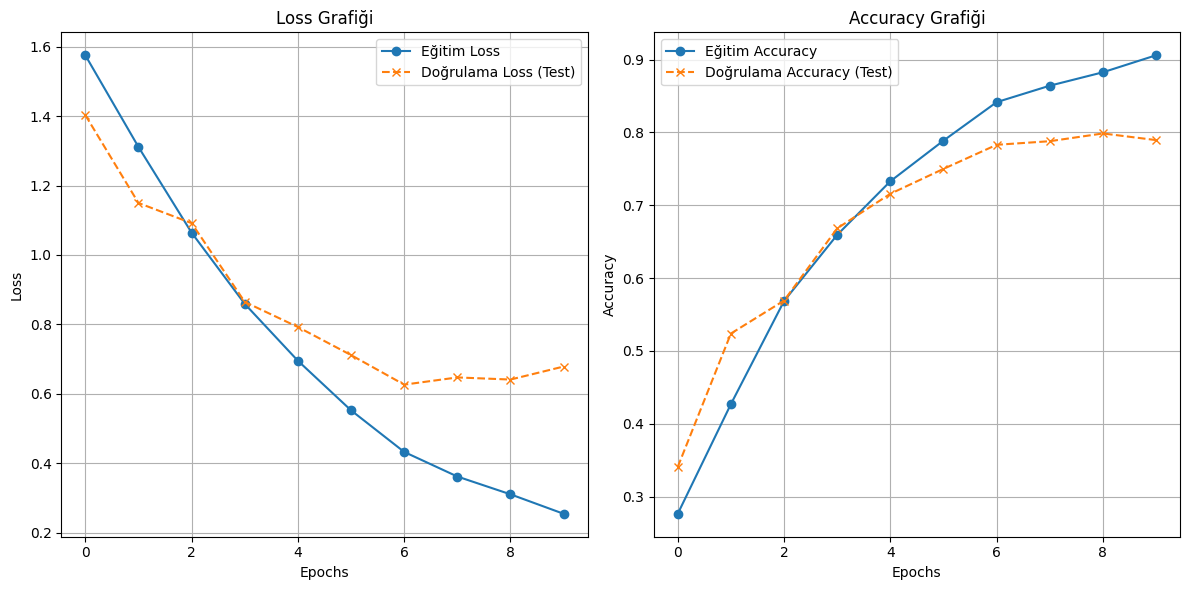

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Test verilerini uygun formatta yükleme
test_data_gen = ImageDataGenerator(rescale=1.0/255)

test_data = test_data_gen.flow_from_directory(
    '/content/drive/My Drive/SPLIT_DATASET/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


# Test kümesi üzerinde modelin doğruluk ve kayıp değerini hesaplama
test_loss, test_accuracy = vit_model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Tahmin yapma
predictions = vit_model.predict(test_data)

# Tahmin edilen sınıflar
predicted_classes = predictions.argmax(axis=-1)

true_classes = test_data.classes

import matplotlib.pyplot as plt

# Grafiklerin çizilmesi
plt.figure(figsize=(12, 6))

# Loss Grafiği (Eğitim ve Test için)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss', marker='o')
plt.plot(history.history['val_loss'], label='Doğrulama Loss (Test)', marker='x', linestyle='--')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Grafiği (Eğitim ve Test için)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Doğrulama Accuracy (Test)', marker='x', linestyle='--')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


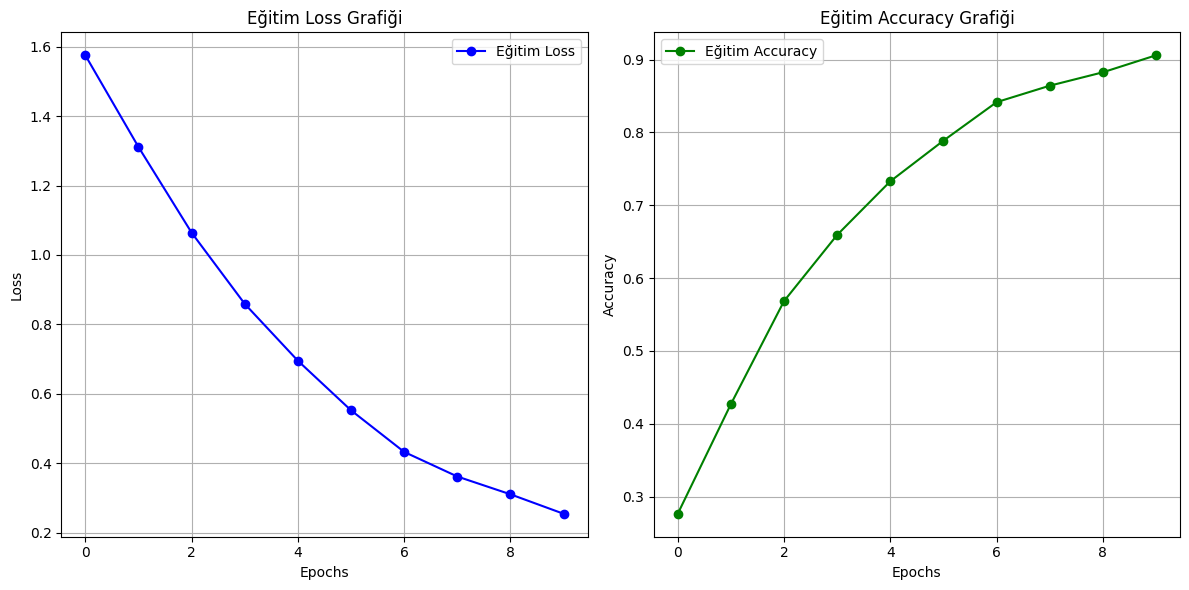

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Çıkarım Süresi: 2.18 saniye
Karmaşıklık Matrisi:
 [[400  37  22  16  41]
 [ 37 398  47  21  23]
 [ 17  57 431  18  18]
 [  9  38  12 456   5]
 [ 49  49  16  22 393]]
Sensitivity (Recall): {0: 0.7751937984496124, 1: 0.7566539923954373, 2: 0.7966728280961183, 3: 0.8769230769230769, 4: 0.7429111531190926}
Specificity: {0: 0.947069943289225, 1: 0.9140550807217473, 2: 0.953610712577714, 3: 0.9635416666666666, 4: 0.9586305278174037}
Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       516
           1       0.69      0.76      0.72       526
           2       0.82      0.80      0.81       541
           3       0.86      0.88      0.87       520
           4       0.82      0.74      0.78       529

    accuracy                           0.79      2632
   macro avg       0.79      0.79      0.79      2632
weighted avg       0.79      0.79      0.79      2632



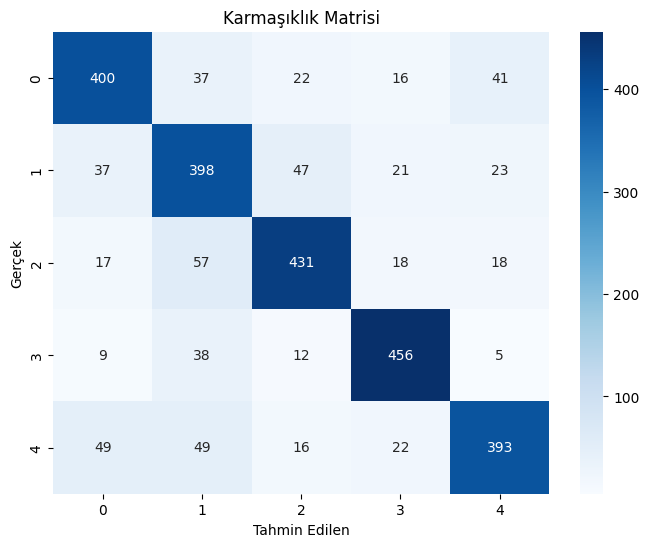

ROC AUC Değerleri:
 {0: 0.9520472479887456, 1: 0.9336027067332517, 2: 0.9539293919632683, 3: 0.9697511472902098, 4: 0.9498564927050832}


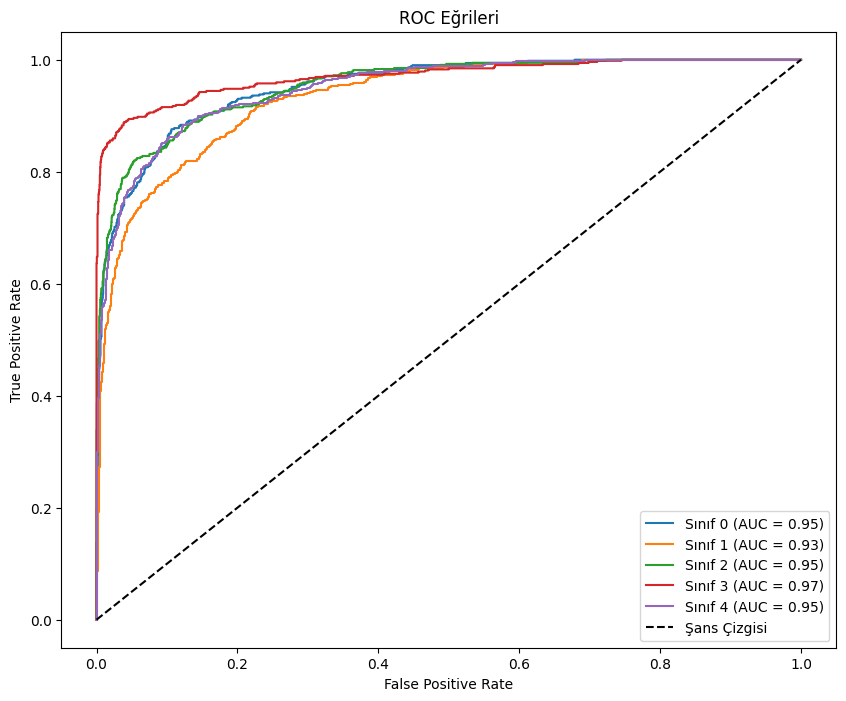

In [ ]:
import time
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Loss Grafiği
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss', marker='o', color='blue')
plt.title('Eğitim Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy', marker='o', color='green')
plt.title('Eğitim Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Test veri kümesi üzerinde çıkarım süresi
start_time = time.time()
y_pred_probs = vit_model.predict(test_dataset)
inference_time = time.time() - start_time
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")

# Metrik hesaplama
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Karmaşıklık Matrisi
conf_matrix = confusion_matrix(y_true, y_pred)
print("Karmaşıklık Matrisi:\n", conf_matrix)

# Sensitivity (Recall) ve Specificity Hesaplama
sensitivity = {}
specificity = {}
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - tp
    fp = conf_matrix[:, i].sum() - tp
    tn = conf_matrix.sum() - (tp + fn + fp)
    sensitivity[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")

# Classification Raporu
class_report = classification_report(y_true, y_pred)
print("Sınıflandırma Raporu:\n", class_report)

# Karmaşıklık Matrisi görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

# ROC Eğrileri ve AUC Hesaplama
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print("ROC AUC Değerleri:\n", roc_auc)

# ROC Eğrileri Görselleştirme
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Sınıf {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Şans Çizgisi')
plt.title('ROC Eğrileri')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


image_paths = [
    '/content/image_1.jpg',
    '/content/image_2.jpg',
    '/content/image_3.jpg',
    '/content/image_4.jpg',
    '/content/image_5.webp'
]


for i, image_path in enumerate(image_paths, 1):

    img = image.load_img(image_path, target_size=(224, 224))  # İndirilen dosya yolunu kullan

    # Fotoğrafı numpy dizisine dönüştürme
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Fotoğrafı normalize etme
    img_array = img_array / 255.0

    # Tahmin yapma
    predictions = vit_model.predict(img_array)

    # Tahmin edilen sınıf
    predicted_class = np.argmax(predictions, axis=-1)

    class_names = list(test_data.class_indices.keys())

    print(f"{i}. Resim: Tahmin Edilen Sınıf: {class_names[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1. Resim: Tahmin Edilen Sınıf: PEKTUS EKSKAVATUM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2. Resim: Tahmin Edilen Sınıf: POLAND SENDROMU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3. Resim: Tahmin Edilen Sınıf: KIFOZ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4. Resim: Tahmin Edilen Sınıf: PEKTUS EKSKAVATUM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5. Resim: Tahmin Edilen Sınıf: SKOLYOZ
